## MATH6380 Project 1: Feature Extraction and Transfer Learning
**Kejing Yin** and **Dong Qian**  
*Department of Computer Science, Hong Kong Baptist University*

**Note**: To run the notebook, Python >= 3.6, PyTorch >= 0.4.0 and pytorchvision are required.

## 1  Introduction
In this project, we make use of the scattering networks and two pre-trained deep neural networks, ResNet18 and AlexNet to extract features from two well-known image datasets, MNIST and CIFAR10. We visualize the extracted features using the traditional dimensionality reduction methods, PCA and t-SNE. Further, we performed classification task using logistic regression.

### Contribution
Both authors contribute equally to this project. More concretly:
- **Kejing Yin** performed the feature extraction using pre-trained deep neural networks and the visualization of the features.  
- **Dong Qian** extracted featrues using scattering networks and performed the classification tasks.  

The discussion on the results and the writing of the report are done by both authors.

### Structure of the Report
In section 2, we briefly introduce the datasets we used in this report. In section 3, we introduce the feature extraction mdoels we used in this report and perform the feature extraction, followed by the visualization using PCA and t-SNE, and the classification using logistic regression and SVM in section 4 and 5 respectively. Finally in section 6, we discuss the results obtained.

In [1]:
import os
from pathlib import Path

import numpy as np
from scipy.io import loadmat

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST
from torchvision import models, transforms

import seaborn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Prepare the computational envrionment
device = torch.device('cuda')

data_dir = Path('./data')
data_dir.mkdir(exist_ok=True)

feature_dir = Path('./features')
feature_dir.mkdir(exist_ok=True)

## 2 Datasets

### 2.1 MNIST

The MNIST dataset is a large dataset of handwritten digits that is widely used for evaluating machine learning algorithms. It contains 60,000 training samples and 10,000 test samples. There are 10 digits (0-9) or 10 classes to predict. Each image is represented by $28 \times 28$ pixels (784 pixels), each containing a value 0-255 with its grayscale value. The MNIST dataset is available at http://yann.lecun.com/exdb/mnist/.

Here are the images in the training dataset per class:

<img src="./figs/mnist.png" width="500">

### 2.2 CIFAR-10

The CIFAR-10 dataset consists of 60,000 images divided into 10 classes, with 6000 images per class. The classes include airplanes, automobiles, cats and so on. There are 50,000 training samples and 10000 test samples. Each image is represented by $32 \times 32$ pixels (1024 pixels) in color with red, green and blue components. The CIFAR-10 dataset is available at https://www.cs.toronto.edu/~kriz/cifar.html.

Here are the images in the training dataset per class:

<img src="./figs/cifar.png" width="600">

In [3]:
# download data if the data do not exist.
MNIST(data_dir/'mnist', download=True)
CIFAR10(data_dir/'cifar10', download=True)
print('Data are well prepared.')

Files already downloaded and verified
Data are well prepared.


## 3  Feature Extraction
In this section, we use the Scattering network and two other pre-trained deep neural networks, ResNet18 and Alexnet, to extract features from the CIFAR10 and MNIST datasets. We first briefly describe each model and then perform the feature extraction.

### 3.1  Raw Features
We first vectorize the images to form the raw features. Namely, each image is reshaped into one single row vector.

In [4]:
raw_mnist_path = feature_dir / 'raw_mnist.pt'
if raw_mnist_path.exists():
    raw_mnist = torch.load(raw_mnist_path)
else:
    mnist_rawdata = {
        'train': MNIST(data_dir/'mnist', transform=transforms.ToTensor()),
        'test': MNIST(data_dir/'mnist', train=False, transform=transforms.ToTensor())
    }
    raw_mnist = {
        'train': (torch.cat([mnist_rawdata['train'][i][0].reshape(1, -1) 
                            for i in range(len(mnist_rawdata['train']))], dim=0),
                  torch.LongTensor([mnist_rawdata['train'][i][1]
                                   for i in range(len(mnist_rawdata['train']))])),

        'test': (torch.cat([mnist_rawdata['test'][i][0].reshape(1, -1)
                           for i in range(len(mnist_rawdata['test']))], dim=0),
                 torch.LongTensor([mnist_rawdata['test'][i][1]
                                  for i in range(len(mnist_rawdata['test']))]))
    }
    torch.save(raw_mnist, raw_mnist_path)

raw_cifar10_path = feature_dir / 'raw_cifar10.pt'
if raw_cifar10_path.exists():
    raw_cifar10 = torch.load(raw_cifar10_path)
else:
    cifar10_rawdata = {
        'train': CIFAR10(data_dir/'cifar10', transform=transforms.ToTensor()),
        'test': CIFAR10(data_dir/'cifar10', train=False, transform=transforms.ToTensor())
    }
    raw_cifar10 = {
        'train': (torch.cat([cifar10_rawdata['train'][i][0].reshape(1, -1)
                            for i in range(len(cifar10_rawdata['train']))], dim=0),
                  torch.LongTensor([cifar10_rawdata['train'][i][1]
                                   for i in range(len(cifar10_rawdata['train']))])),

        'test': (torch.cat([cifar10_rawdata['test'][i][0].reshape(1, -1)
                            for i in range(len(cifar10_rawdata['test']))], dim=0),
                 torch.LongTensor([cifar10_rawdata['test'][i][1]
                                   for i in range(len(cifar10_rawdata['test']))]))
    }
    torch.save(raw_cifar10, raw_cifar10_path)

### 3.2 Wavelet Scattering Network

The wavelet scattering network [1] learns translation-invariant representations of the images and preserves high frequency information for computer vision tasks. It cascades wavelet transform convolutions with non-linear modulus and averaging operators. The first network layer outputs SIFT-type descriptors whereas the next layers provide complementary invariant information which improves classification. The mathematical analysis of wavelet scattering networks explains important properties of deep convolution networks for classification. The architecture of the ScatNet is:

<img src="./figs/ScatNet.png" width="500">

#### 3.2.1 ScatNet on MNIST

1. Load an image of the MNIST dataset (e.g. digit '5', $28 \times 28$).
<img src="./figs/Mnist_matlab.png" width="200">

2. Use the package ScatNet 2.0 from ENS in Matlab to compute the wavelet transform operators. Parameter setting:
    1. filt_opt.J is the number of scale in the filter bank.
    2. filt_opt.L is the number of orientations.
    3. scat_opt.M is the maximum scattering order.

<img src="./figs/filter.png" width="500">

As shown in this figure, the top filters correspond to filt_opt.J = 2, filt_opt.L = 6 and scat_opt.M = 2, while the bottom filters correspond to filt_opt.J = 3, filt_opt.L = 6 and scat_opt.M = 2. In the first case, the top left image corresponds to $\phi$. The first left half corresponds to the real parts of $\psi_{j, \theta}$, arranged according scales (rows) and orientations (columns). The right half image corresponds to the imaginary part. 

3. Display all representations derived by ScatNet based on two different parameter setttings. The dimensionality of feature vectors is 49 and 127, respectively.

<img src="./figs/ScatFeature.png" width="600">

Note that increasing filt_opt.J from 2 to 3 will increase the range of translation invariance.

#### 3.2.2 ScatNet on CIFAR10

The difference between MNIST and CIFAR10 is the number of channels. The images in the CIFAR10 dataset are in colour with red, green and black components. Therefore, we implemented ScatNet on each channel and then concatenate the learned feature together as a single vector.

We implemented the same procedures. 

<img src="./figs/cifar_filter.png" width="800">

#### 3.2.3 Implementation
We use [MATLAB toolkit](https://www.di.ens.fr/data/software/) to implement the ScatNet feature extraction and save the results after extract. In the following code block, we load the extrated features for further analysis.

In [21]:
# load the scattering features
scattering_dir = Path('./scattering/features/')
scattering_mnist = {}
scattering_cifar10 = {}

for J, L, M in [(2, 6, 2), (3, 6, 2), (5, 6, 2)]:
    scattering_mnist[f'J{J}L{L}M{M}'] = {
        'train': (loadmat(scattering_dir/f'MNIST_J{J}L{L}M{M}'/'feature_train.mat')['feature_train'],
                  loadmat(scattering_dir/'MNIST_Label'/'label_train.mat')['label_train'].reshape(-1)),
        'test': (loadmat(scattering_dir/f'MNIST_J{J}L{L}M{M}'/'feature_test.mat')['feature_test'],
                 loadmat(scattering_dir/'MNIST_Label'/'label_test.mat')['label_test'].reshape(-1))
    }
    scattering_cifar10[f'J{J}L{L}M{M}'] = {  # size
        'train': (loadmat(scattering_dir/f'CIFAR10_J{J}L{L}M{M}'/'feature_train.mat')['feature_train'],
                  loadmat(scattering_dir/'CIFAR10_Label'/'label_train.mat')['label_train'].reshape(-1)),
        'test': (loadmat(scattering_dir/f'CIFAR10_J{J}L{L}M{M}'/'feature_test.mat')['feature_test'],
                 loadmat(scattering_dir/'CIFAR10_Label'/'label_test.mat')['label_test'].reshape(-1))
    }

### 3.3 ResNet-18

The residual neural network [3] is arguably the most groundbreaking work in the computer vision and deep learning community in the last few years. The ResNet makes it possible to train up to hundreds or even thousands of layers and still achieves compelling performance. It achieve this by introducing a identity shortcut connection that jumps over one or more layers. This indicates that the deeper model should not produce a training error higher than its shallower counterparts. The architecture of the ResNet is:

<img src="./figs/ResNet.png" width="700">

In this project, we use the ResNet-18 model pre-trained with the ImageNet dataset implemented in [pytorchvision](https://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
# The model is pre-trained with image net dataset, thus normalization of input is required.
# We first resize the input images, and convert the image to tensor format, and lastly normalize the
# input images using the mean and std specified by the pre-trained model we used.
cifar10_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

mnist_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

# After defining the transformation needed, we can now load and transform the datasets.
cifar10_train = CIFAR10(data_dir/'cifar10', transform=cifar10_transform)
cifar10_test = CIFAR10(data_dir/'cifar10', train=False, transform=cifar10_transform)

mnist_train = MNIST(data_dir/'mnist', transform=mnist_transform)
mnist_test = MNIST(data_dir/'mnist', train=False, transform=mnist_transform)

In [7]:
# Function to extract features using the given model.
def extract_features(model, datasets, datasetname, batch_size=10, device=device):
    features = {}
    for name, data in datasets.items():
        data_feature = torch.FloatTensor()
        data_labels = torch.LongTensor()
        with torch.no_grad():
            dataloader = DataLoader(data, batch_size=batch_size)
            print(f'Extracting features from {datasetname} ({name}):')
            print(f'  Number of processed samples: ({len(data)} samples in total.)', end='\n  ')
            for i, (inputs, labels) in enumerate(dataloader):
                bfeature = model(inputs.to(device))
                data_feature = torch.cat([
                    data_feature,
                    bfeature.reshape(bfeature.shape[0], -1).cpu()], dim=0)
                data_labels = torch.cat([data_labels, labels], dim=0)
                if (i + 1) % 100 == 0 or i==len(dataloader):
                    print(i*batch_size+len(inputs), end='...')
            print('Done.\n')
        features[name] = (data_feature, data_labels)
    return features

In [8]:
# load the pre-trained ResNet18 model.
resnet18 = models.resnet18(pretrained=True)  # load the pre-trained model.
resnet18_features = nn.Sequential(*list(resnet18.children())[:-1]).to(device)  # Remove the last layer (classification).

In [9]:
# Extract features from MNIST dataset.
resnet18_mnist_path = feature_dir / 'resnet18_mnist.pt'
if resnet18_mnist_path.exists():
    resnet18_mnist = torch.load(resnet18_mnist_path)
    print('Features loaded from file.')
else:
    resnet18_mnist = extract_features(resnet18_features, 
                                      {'train': mnist_train, 'test': mnist_test}, 'MNIST',
                                      batch_size=100)
    torch.save(resnet18_mnist, resnet18_mnist_path)

Features loaded from file.


In [10]:
# Extract features from CIFAR10 dataset.
resnet18_cifar10_path = feature_dir / 'resnet18_cifar10.pt'
if resnet18_cifar10_path.exists():
    resnet18_cifar10 = torch.load(resnet18_cifar10_path)
    print('Features loaded from file.')
else:
    resnet18_cifar10 = extract_features(resnet18_features, 
                                        {'train': cifar10_train, 'test': cifar10_test}, 'CIFAR10',
                                        batch_size=100)
    torch.save(resnet18_cifar10, resnet18_cifar10_path)

Features loaded from file.


### 3.4 AlexNet

The AlexNet [2] is the name of a convolutional neural network, invented by Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton in 2012. It has a large impact on the application of deep learning to computer vision tasks. The AlexNet won the 2012 ImageNet Large Scale Visual Recognition Challenge with a top-5 error of 15.3%. The highlights of the Alexnet are the use of ReLU activation function, dropout and the depth of the layers. The architecure of the AlexNet is:

<img src="./figs/AlexNet.png" width="600">

In this project, we use the AlexNet model pre-trained with the ImageNet dataset implemented in [pytorchvision](https://pytorch.org/docs/stable/torchvision/models.html).

In [30]:
# load the pre-trained Alexnet model.
alexnet = models.alexnet(pretrained=True)
alexnet_features = nn.Sequential(*list(alexnet.children())[:-1]).to(device)

In [31]:
# Extract features from MNIST dataset.
alexnet_mnist_path = feature_dir / 'alexnet_mnist.pt'
if alexnet_mnist_path.exists():
    alexnet_mnist = torch.load(alexnet_mnist_path)
    print('Features loaded from file.')
else:
    alexnet_mnist = extract_features(alexnet_features, 
                                     {'train': mnist_train, 'test': mnist_test}, 'MNIST',
                                     batch_size=100)
    torch.save(alexnet_mnist, alexnet_mnist_path)

Features loaded from file.


In [32]:
# Extract features from CIFAR10 dataset.
alexnet_cifar10_path = feature_dir / 'alexnet_cifar10.pt'
if alexnet_cifar10_path.exists():
    alexnet_cifar10 = torch.load(alexnet_cifar10_path)
    print('Features loaded from file.')
else:
    alexnet_cifar10 = extract_features(alexnet_features, 
                                       {'train': cifar10_train, 'test': cifar10_test}, 'CIFAR10',
                                       batch_size=100)
    torch.save(alexnet_cifar10, alexnet_cifar10_path)

Features loaded from file.


## 4 Feature Visualization
We use two classic unsupervised methods, PCA and t-SNE, for visualizing the extracted features.

### 4.1 Principal Component Analysis (PCA) 
Principal component analysis (PCA) is commonly used dimensionality reduction tool. PCA use an orthogonal projection to transform the input data to find a set of linearly independent variables, which are called principal components. To visualize the high dimensional data, we set the number of components to be two in order to plot the data in a 2D plane.

In [23]:
vis_dir = Path('./visualization')
vis_dir.mkdir(exist_ok=True)

In [26]:
# since t-SNE is slow, we can do that in multiple machines and then collect the results to plot the figures.
def perform_or_load_dimensionality_reduction(dim_reduc, features, filepath, recompute):
    if filepath.exists() and not recompute:
        reduced_features = np.load(filepath)
    else:
        reduced_features = dim_reduc.fit_transform(features)
        np.save(filepath, reduced_features)
    return reduced_features    

def visualize_features(dim_reduc, feature_sets, fig_title, force_recompute=False, m=2, n=3, figsize=(16, 10)):
    fig, axes = plt.subplots(m, n, figsize=figsize)
    for i, (name, filepath, features, labels) in enumerate(feature_sets):
        reduced_features = perform_or_load_dimensionality_reduction(dim_reduc, features, filepath, recompute=force_recompute)
        axis = axes[i//n, i%n]
        axis.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels)
        axis.set_title(name)
        axis.axis('off')
    fig.suptitle(fig_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

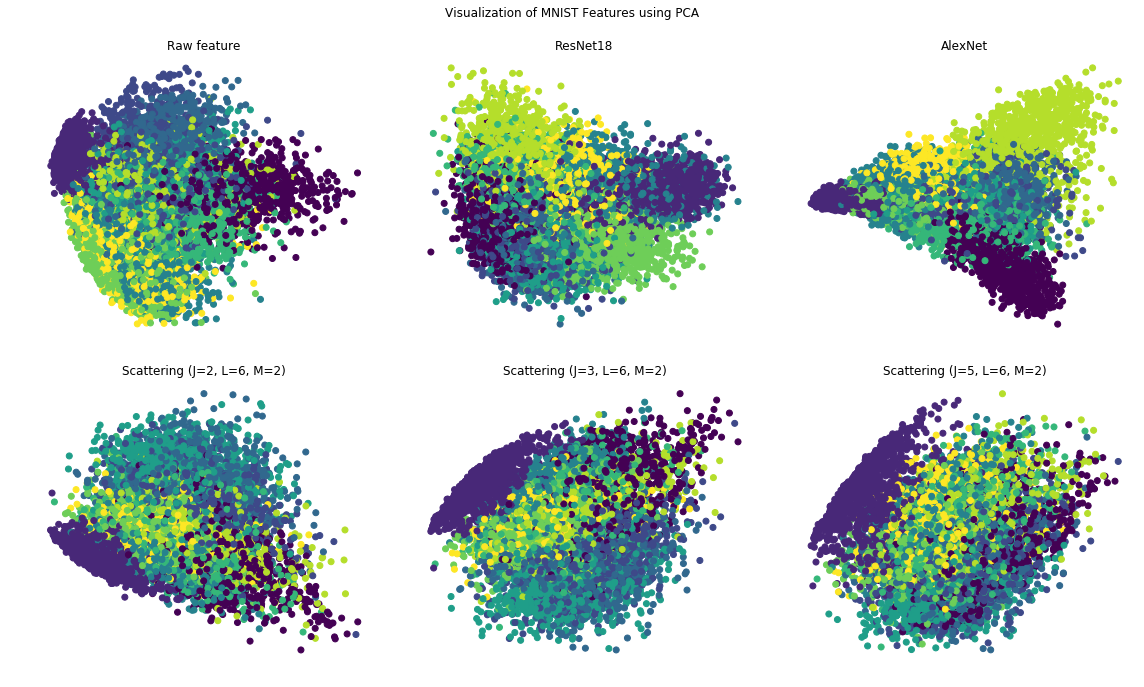

In [34]:
recompute = False  # switch to True to force recomputing the dimensionality reduction instead of loading existing ones.
pca = PCA(n_components=2)
mnist_feature_sets = [
    ['Raw feature', vis_dir/'pca_mnist_raw.npy'] + list(raw_mnist['test']),
    ['ResNet18', vis_dir/'pca_mnist_resnet18.npy'] + list(resnet18_mnist['test']),
    ['AlexNet', vis_dir/'pca_mnist_alexnet.npy'] + list(alexnet_mnist['test']),
    ['Scattering (J=2, L=6, M=2)', vis_dir/'pca_mnist_J2L6M2.npy'] + list(scattering_mnist['J2L6M2']['test']),
    ['Scattering (J=3, L=6, M=2)', vis_dir/'pca_mnist_J3L6M2.npy'] + list(scattering_mnist['J3L6M2']['test']),
    ['Scattering (J=5, L=6, M=2)', vis_dir/'pca_mnist_J5L6M2.npy'] + list(scattering_mnist['J5L6M2']['test']),
]
fig = visualize_features(pca, mnist_feature_sets, 'Visualization of MNIST Features using PCA', recompute)
fig.savefig(vis_dir/'pca_mnist.png', dpi=300)

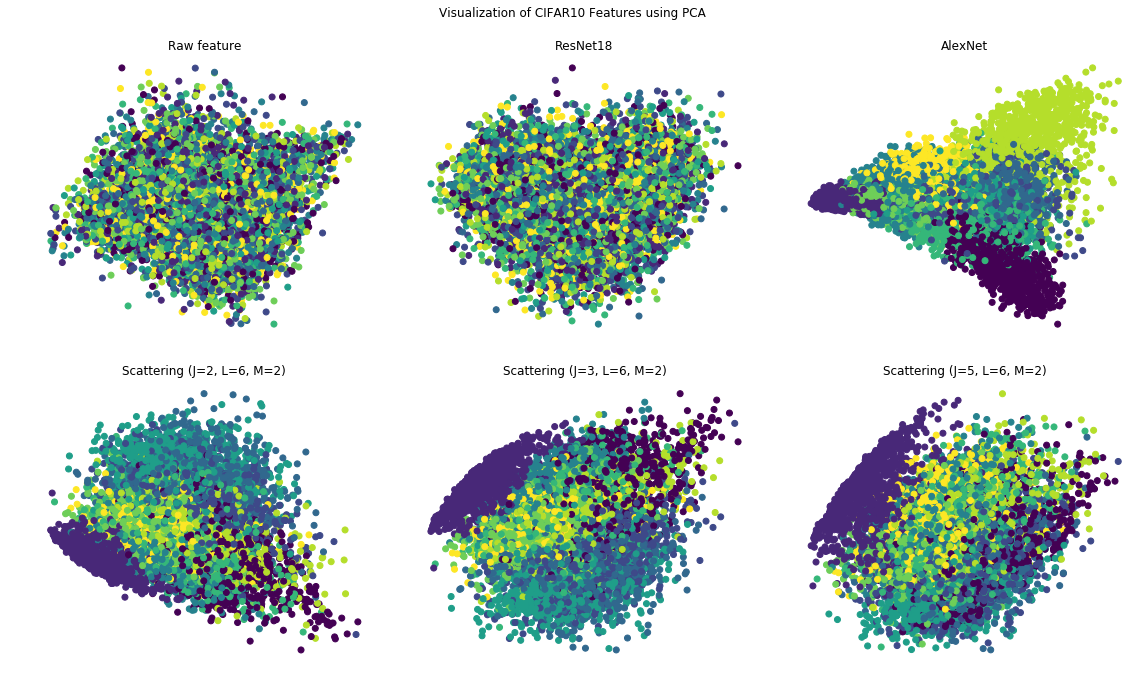

In [35]:
recompute = False  # switch to True to force recomputing the dimensionality reduction instead of loading existing ones.
pca = PCA(n_components=2)
cifar10_feature_sets = [
    ['Raw feature', vis_dir/'pca_cifar10_raw.npy'] + list(raw_mnist['test']),
    ['ResNet18', vis_dir/'pca_cifar10_resnet18.npy'] + list(resnet18_mnist['test']),
    ['AlexNet', vis_dir/'pca_cifar10_alexnet.npy'] + list(alexnet_mnist['test']),
    ['Scattering (J=2, L=6, M=2)', vis_dir/'pca_cifar10_J2L6M2.npy'] + list(scattering_mnist['J2L6M2']['test']),
    ['Scattering (J=3, L=6, M=2)', vis_dir/'pca_cifar10_J3L6M2.npy'] + list(scattering_mnist['J3L6M2']['test']),
    ['Scattering (J=5, L=6, M=2)', vis_dir/'pca_cifar10_J5L6M2.npy'] + list(scattering_mnist['J5L6M2']['test']),
]
fig = visualize_features(pca, cifar10_feature_sets, 'Visualization of CIFAR10 Features using PCA', recompute)
fig.savefig(vis_dir/'pca_cifar10.png', dpi=300)

### 4.2 t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a well-known dimensionality reduction tool that is commonly used for visualizing high-dimensional data. t-SNE calculates the similarities between data points, and convert it to the joint probabilities and then minimize the KL divergence between the joint probability distribution of the low-dimensional embedding and the high-dimensional input data. In this project, we set the dimension of the embedding space to be two in order to plot the data in a 2D plane.

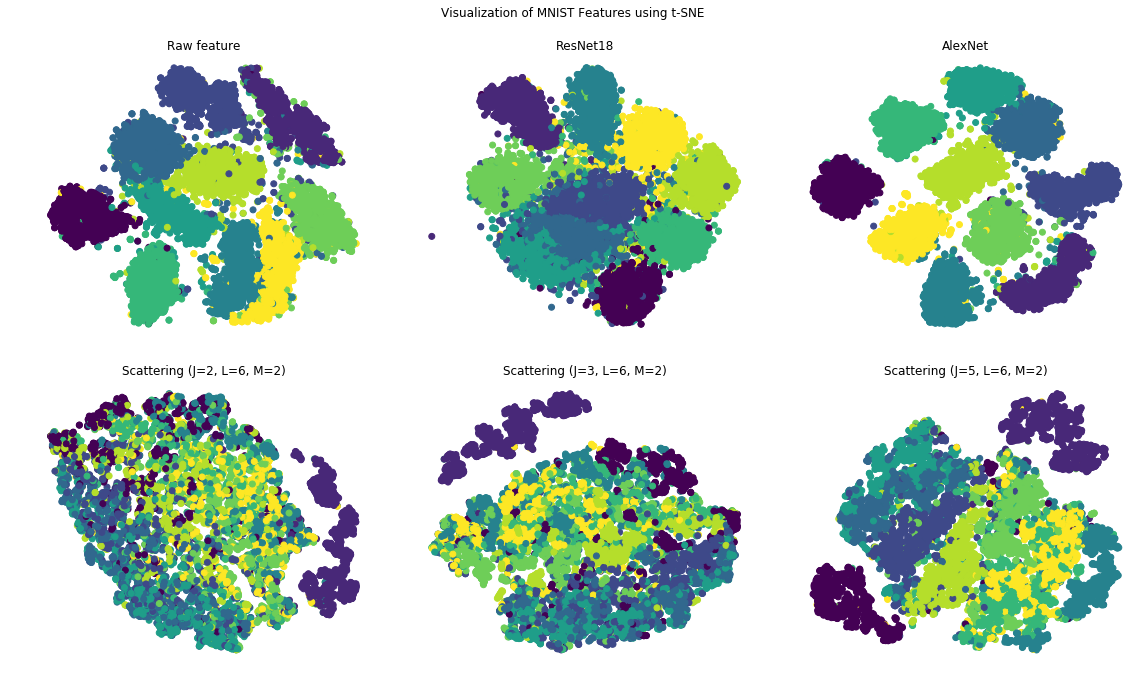

In [40]:
tsne = TSNE(n_components=2)
mnist_feature_sets = [
    ['Raw feature', vis_dir/'tsne_mnist_raw.npy'] + list(raw_mnist['test']),
    ['ResNet18', vis_dir/'tsne_mnist_resnet18.npy'] + list(resnet18_mnist['test']),
    ['AlexNet', vis_dir/'tsne_mnist_alexnet.npy'] + list(alexnet_mnist['test']),
    ['Scattering (J=2, L=6, M=2)', vis_dir/'tsne_mnist_J2L6M2.npy'] + list(scattering_mnist['J2L6M2']['test']),
    ['Scattering (J=3, L=6, M=2)', vis_dir/'tsne_mnist_J3L6M2.npy'] + list(scattering_mnist['J3L6M2']['test']),
    ['Scattering (J=5, L=6, M=2)', vis_dir/'tsne_mnist_J5L6M2.npy'] + list(scattering_mnist['J5L6M2']['test']),
]
fig = visualize_features(tsne, mnist_feature_sets, 'Visualization of MNIST Features using t-SNE')
fig.savefig(vis_dir/'tsne_mnist.png', dpi=300)

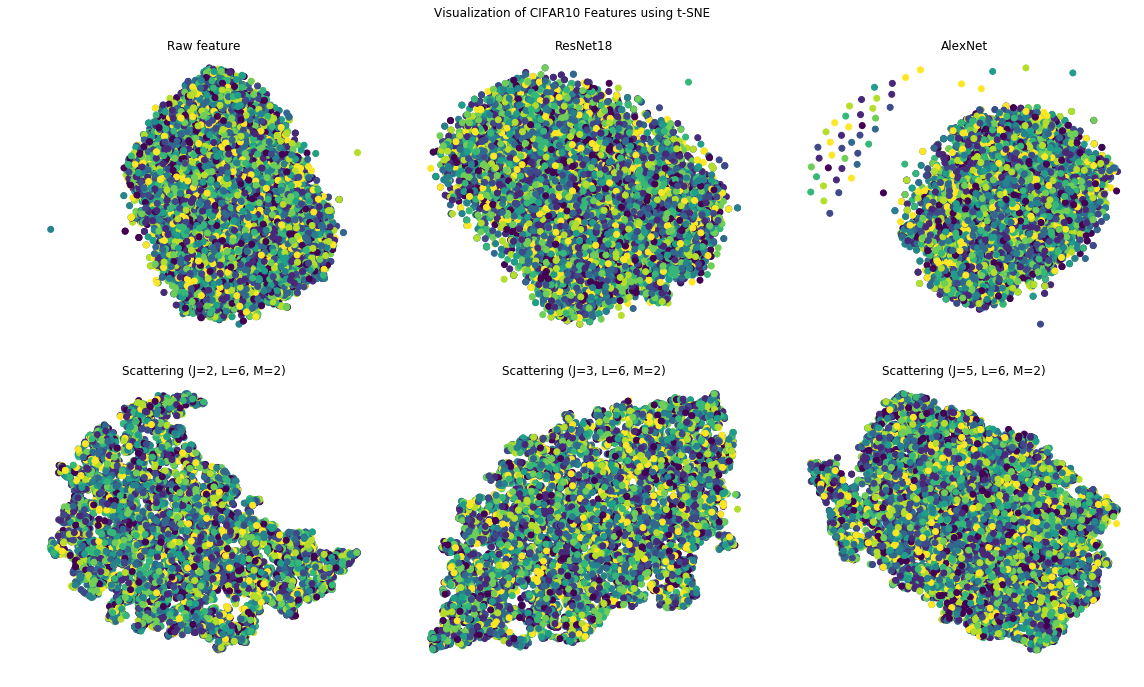

In [41]:
tsne = TSNE(n_components=2)
mnist_feature_sets = [
    ['Raw feature', vis_dir/'tsne_cifar10_raw.npy'] + list(raw_mnist['test']),
    ['ResNet18', vis_dir/'tsne_cifar10_resnet18.npy'] + list(resnet18_mnist['test']),
    ['AlexNet', vis_dir/'tsne_cifar10_alexnet.npy'] + list(alexnet_mnist['test']),
    ['Scattering (J=2, L=6, M=2)', vis_dir/'tsne_cifar10_J2L6M2.npy'] + list(scattering_mnist['J2L6M2']['test']),
    ['Scattering (J=3, L=6, M=2)', vis_dir/'tsne_cifar10_J3L6M2.npy'] + list(scattering_mnist['J3L6M2']['test']),
    ['Scattering (J=5, L=6, M=2)', vis_dir/'tsne_cifar10_J5L6M2.npy'] + list(scattering_mnist['J5L6M2']['test']),
]
fig = visualize_features(tsne, mnist_feature_sets, 'Visualization of CIFAR10 Features using t-SNE')
fig.savefig(vis_dir/'tsne_cifar10.png', dpi=300)

## 5  Classification
In this project, we use the logistic regression with l2-norm regularization to perform the classification task. We use **accuracy** to measure the performance. Unfortunately, the feature dimension of AlexNet is too large, so we donot perform classification task with the features extracted by AlexNet.

In [52]:
def logistic_regression(Xtrain, ytrain, Xtest, ytest, n_jobs=os.cpu_count()-1):
    normalizer = Normalizer().fit(Xtrain)  # normalize the features using l2-norm, to accelerate convergence.
    # lr = LogisticRegressionCV(Cs=10, cv=5, solver='sag', multi_class='multinomial', n_jobs=n_jobs)
    lr = LogisticRegression(solver='sag', multi_class='multinomial')
    lr.fit(normalizer.transform(Xtrain), ytrain)
    acc_train = accuracy_score(ytrain, lr.predict(normalizer.transform(Xtrain)))
    acc_test = accuracy_score(ytest, lr.predict(normalizer.transform(Xtest)))
    return acc_train, acc_test

In [47]:
# Raw Features
Xtrain, ytrain, Xtest, ytest = raw_mnist['train'] + raw_mnist['test']
raw_mnist_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)
Xtrain, ytrain, Xtest, ytest = raw_cifar10['train'] + raw_cifar10['test']
raw_cifar10_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)

In [45]:
# ResNet-18
Xtrain, ytrain, Xtest, ytest = resnet18_mnist['train'] + resnet18_mnist['test']
resnet18_mnist_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)
Xtrain, ytrain, Xtest, ytest = resnet18_cifar10['train'] + resnet18_cifar10['test']
resnet18_cifar10_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)

In [48]:
# Scattering Net with parameters J=2, L=6, M=2
Xtrain, ytrain, Xtest, ytest = scattering_mnist['J2L6M2']['train'] + scattering_mnist['J2L6M2']['test']
scattering_J2L6M2_mnist_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)
Xtrain, ytrain, Xtest, ytest = scattering_cifar10['J2L6M2']['train'] + scattering_cifar10['J2L6M2']['test']
scattering_J2L6M2_cifar10_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)

In [49]:
# Scattering Net with parameters J=3, L=6, M=2
Xtrain, ytrain, Xtest, ytest = scattering_mnist['J3L6M2']['train'] + scattering_mnist['J3L6M2']['test']
scattering_J3L6M2_mnist_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)
Xtrain, ytrain, Xtest, ytest = scattering_cifar10['J3L6M2']['train'] + scattering_cifar10['J3L6M2']['test']
scattering_J3L6M2_cifar10_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)

In [50]:
# Scattering Net with parameters J=5, L=6, M=2
Xtrain, ytrain, Xtest, ytest = scattering_mnist['J5L6M2']['train'] + scattering_mnist['J5L6M2']['test']
scattering_J5L6M2_mnist_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)
Xtrain, ytrain, Xtest, ytest = scattering_cifar10['J5L6M2']['train'] + scattering_cifar10['J5L6M2']['test']
scattering_J5L6M2_cifar10_acc = logistic_regression(Xtrain, ytrain, Xtest, ytest)

In [63]:
print('Results:')
print('   MNIST\t  CIFAR10')
print('train\ttest\ttrain\ttest')
print(f'{raw_mnist_acc[0]:.2f}\t{raw_mnist_acc[1]:.2f}\t{raw_cifar10_acc[0]:.2f}\t{raw_cifar10_acc[1]:.2f}', 'Raw')

print(f'{resnet18_mnist_acc[0]:.2f}\t{resnet18_mnist_acc[1]:.2f}\t'
      f'{resnet18_cifar10_acc[0]:.2f}\t{resnet18_cifar10_acc[1]:.2f}', 'ResNet-18')

print(f'{scattering_J2L6M2_mnist_acc[0]:.2f}\t{scattering_J2L6M2_mnist_acc[1]:.2f}\t'
      f'{scattering_J2L6M2_cifar10_acc[0]:.2f}\t{scattering_J2L6M2_cifar10_acc[1]:.2f}', 'Scattering (J=2, L=6, M=2)')

print(f'{scattering_J3L6M2_mnist_acc[0]:.2f}\t{scattering_J3L6M2_mnist_acc[1]:.2f}\t'
      f'{scattering_J3L6M2_cifar10_acc[0]:.2f}\t{scattering_J3L6M2_cifar10_acc[1]:.2f}', 'Scattering (J=3, L=6, M=2)')

print(f'{scattering_J5L6M2_mnist_acc[0]:.2f}\t{scattering_J5L6M2_mnist_acc[1]:.2f}\t'
      f'{scattering_J5L6M2_cifar10_acc[0]:.2f}\t{scattering_J5L6M2_cifar10_acc[1]:.2f}', 'Scattering (J=5, L=6, M=2)')

# print(resnet18_mnist_acc, resnet18_cifar10_acc)
# print(scattering_J2L6M2_mnist_acc, scattering_J2L6M2_cifar10_acc)
# print(scattering_J3L6M2_mnist_acc, scattering_J3L6M2_cifar10_acc)
# print(scattering_J5L6M2_mnist_acc, scattering_J5L6M2_cifar10_acc)

Results:
   MNIST	  CIFAR10
train	test	train	test
0.92	0.92	0.42	0.41 Raw
0.96	0.96	0.81	0.79 ResNet-18
0.64	0.66	0.36	0.37 Scattering (J=2, L=6, M=2)
0.85	0.85	0.40	0.40 Scattering (J=3, L=6, M=2)
0.93	0.93	0.44	0.44 Scattering (J=5, L=6, M=2)


### 6 Discussion
#### 6.1 Visualization and Classification Results
1. MNIST is a simple dataset, so all methods except the ScatNet with J=2 perform reasonably well for classification task on the MNIST dataset, even the vectorized raw input can achieve accuracy of 0.92.  
2. On CIFAR-10, the raw features perform much worse, as the CIFAR-10 dataset is much more complex than the MNIST one. The ResNet-18 model performed best, achieving accuracy of 0.79.  
3. With the value of J increasing, the number of features extracted increas significantly, resulting in the better features being extracted and hence better classification performance.

#### 6.2 General Discussion
A major difficulty of image classification comes from the considerable variability within image classes and the inability of Euclidean distances to measure image. A good representation should contain compact and faithful information of data, explicitly represent the attributes required for the task at hand. It is desirable to design learning algorithms that should be able to automatically learn high-level representations from high-dimensional data. In such way, these algorithms could avoid the curse of dimensionality and discover the low-dimensional manifold of the data that probability mass is highly concentrated.

The filters in a Convolutional Neural Network (CNN) corresponds to the weights that are learned from a large number of data. These filters are typically randomly initialized and then updated by using back-propagation training algorithm. As a result, they have no specific structures and could not be interpreted by humans. The ScatNet is designed to cascade wavelet transform convolutions with nonlinear modulus and averaging operators for translation-invariant representations. With the predefined filters, human could impose more controls the number of model parameters and robustness. Also, the learned representations of the ScatNet are interpretable. Filters with improved properties will have an impact on the efficiency and interpretability of CNNs, and help to understand deep neural networks. Hopefully, the CNNs with predefined filters could be invariant to adversarial examples.

### References

[1] Joan Bruna and Stéphane Mallat. Invariant Scattering Convolution Networks. IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 35, no. 8, pp. 1872--1886, 2012.

[2] Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton. ImageNet Classification with Deep Convolutional Neural Networks. In Advances in Neural Information Processing Systems, pp. 1097--1105, 2012.

[3] Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. Deep Residual Learning for Image Recognition. In IEEE Conference on Computer Vision and Pattern Recognition, pp. 770--778, 2016.

[4] Gao Huang, Zhuang Liu, Laurens van der Maaten and Kilian Q. Weinberger. Densely Connected Convolutional Networks. In IEEE Conference on Computer Vision and Pattern Recognition, pp. 2261--2269, 2017.